Imports


In [1]:
import numpy as np
import pandas as pd
import gym
from gym import Env
from gym.spaces import Box, Discrete, MultiDiscrete
import os
import tensorflow
from tensorflow.keras.models import Sequential

from tensorflow.keras.optimizers import Adam

from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import Adam
import random
from tensorflow.keras.layers import Input
import matplotlib.pyplot as plt
import pickle
from scipy.optimize import minimize
import itertools
import scipy.stats as st
import numpy as np
import mplfinance as mpf

Generating data

In [2]:
def generate_ohlc_data(means, correlation_matrix, num_days=5040, num_timesteps=24):
    column_names = [f'Stock_{i+1}_{col}' for i in range(len(means)) for col in ['Open', 'High', 'Low', 'Close']]
    ohlc_data = []
    
    # Fill the first row with ones
    ohlc_data.append([1] * len(column_names))

    for day in range(num_days):
        # Generate data for one day
        a = st.multivariate_normal.rvs(means, correlation_matrix, size=(1, num_timesteps))
        a = np.exp(a)
        lity = []
        #print(a)
        
        for timestep in range(len(a[0])):
            close_prev = ohlc_data[-1][3 + timestep * 4]
            #print(np.cumsum(a[:,timestep]) , close_prev)
            
            lity.append(close_prev)
            lity.append(close_prev * max(np.cumprod(a[:, timestep])))  # High
            lity.append(close_prev * min(np.cumprod(a[:, timestep])))  # Low
            lity.append(close_prev * np.cumprod(a[:, timestep])[-1])   # Close
        #print(lity)
        
        ohlc_data.append((lity))
    
    return pd.DataFrame(ohlc_data, columns=column_names)

means = [0.00003, 0.00002]
correlation_matrix = np.array([[0.000034, 0.0000075],
                               [0.0000075, 0.000012]
])


OHLC = generate_ohlc_data(means=means, correlation_matrix=correlation_matrix)
OHLC = OHLC.drop(OHLC.index[0]).reset_index(drop=True)

OHLC.tail()

Stock_1_Open  Stock_1_High  Stock_1_Low  Stock_1_Close  Stock_2_Open  \
5035    538.498910    538.686353   519.338649     521.339639     40.159088   
5036    521.339639    530.883038   517.984178     518.019456     39.932289   
5037    518.019456    530.099740   510.510739     524.654466     39.839638   
5038    524.654466    528.378310   512.622967     522.722239     40.309140   
5039    522.722239    530.017058   516.200541     522.695219     39.619761   

      Stock_2_High  Stock_2_Low  Stock_2_Close  
5035     40.173088    39.537588      39.932289  
5036     40.387701    39.836455      39.839638  
5037     40.602202    39.783235      40.309140  
5038     40.347622    39.460384      39.619761  
5039     40.430192    39.538268      39.852144

In [3]:
# Load the data
IBM = pd.read_csv('IBM.csv')
KO = pd.read_csv('KO.csv')
merged_df = pd.merge(KO, IBM, on='Date', suffixes=('_KO', '_IBM'))
columns_to_drop = ['Adj Close_KO', 'Volume_KO', 'Adj Close_IBM', 'Volume_IBM']
merged_df.drop(columns=columns_to_drop, inplace=True)
merged_df.drop(columns=['Date'], inplace=True) 
merged_df.rename(columns={
    'Open_KO': 'Stock_1_Open',
    'High_KO': 'Stock_1_High',
    'Low_KO': 'Stock_1_Low',
    'Close_KO': 'Stock_1_Close',
    'Open_IBM': 'Stock_2_Open',
    'High_IBM': 'Stock_2_High',
    'Low_IBM': 'Stock_2_Low',
    'Close_IBM': 'Stock_2_Close'
}, inplace=True)
merged_df.head()

Stock_1_Open  Stock_1_High  Stock_1_Low  Stock_1_Close  Stock_2_Open  \
0     26.174999     26.200001    25.955000      26.084999     94.120461   
1     25.799999     25.969999    25.555000      25.900000     94.837479   
2     25.660000     25.850000    25.645000      25.770000     95.659653   
3     25.990000     25.990000    25.525000      25.570000     94.741875   
4     25.650000     25.690001    25.450001      25.570000     95.592735   

   Stock_2_High  Stock_2_Low  Stock_2_Close  
0     95.573616    94.082214      95.229446  
1     95.898659    94.455070      95.564056  
2     95.889099    94.933075      94.933075  
3     95.688339    94.722755      95.325050  
4     95.602295    94.952202      95.000000

Standardize Data

In [4]:
def StandardizeData(data, n):
    if isinstance(data, pd.DataFrame):
        df = data.copy()  # Make a copy to avoid modifying the original DataFrame
    elif isinstance(data, list):
        df = pd.DataFrame(data)  # Convert list to DataFrame
    else:
        raise ValueError("Input data must be a DataFrame or a list.")
    
    Standardized = pd.DataFrame()
    for col in df.columns:
        ST = pd.DataFrame()
        for i in range(n+1):
            stock_num = int(col.split('_')[1])  # Extract the stock number from the column name
            close_col = f'Stock_{stock_num}_Close'  # Get the corresponding 'Close' column
            ST[f'{col}_{i}'] = df[col].shift(-i) / df[close_col].shift(-n)  # Divide by the corresponding 'Close' column
        Standardized = pd.concat([Standardized, ST], axis=1)
    
    # Drop rows with NaN values
    


    Ratio = pd.DataFrame()
    close_columns = [col for col in df.columns if 'Close' in col]
    for col in close_columns:
        
        Ratio[col] = (df[col].shift(-n-1) /df[col].shift(-n) )-1
        Ratio.dropna()


    return Standardized[:-n-1], Ratio[:-n-1]

InputStates, RewardVector = StandardizeData(merged_df, 4)
print(RewardVector.iloc[:2529].cov() , RewardVector.iloc[:2529].mean())

               Stock_1_Close  Stock_2_Close
Stock_1_Close       0.000139       0.000071
Stock_2_Close       0.000071       0.000184 Stock_1_Close    0.000229
Stock_2_Close    0.000342
dtype: float64


Data transformations

In [6]:
with pd.ExcelWriter('dfmainset.xlsx') as writer:
    RewardVector.to_excel(writer, sheet_name='RewardVector', index=False)
    InputStates.to_excel(writer, sheet_name='InputStates', index=False)

In [7]:
with pd.ExcelFile('dfmainset.xlsx') as xls:
    RewardVector = pd.read_excel(xls, 'RewardVector')
    InputStates = pd.read_excel(xls, 'InputStates')

In [10]:
filtered_df = InputStates[[col for col in InputStates.columns if 'close' in col.lower() and col not in ['Stock_1_Close_0', 'Stock_2_Close_0', 'Stock_1_Close_4', 'Stock_2_Close_4']]]

filtered_df

Stock_1_Close_1  Stock_1_Close_2  Stock_1_Close_3  Stock_2_Close_1  \
0            1.012906         1.007822         1.000000         1.005937   
1            1.005855         0.998048         0.998048         1.008941   
2            1.002745         1.002745         1.004706         1.019530   
3            1.003926         1.005889         1.001178         1.021169   
4            1.017878         1.013111         1.011919         1.025636   
...               ...              ...              ...              ...   
5044         1.013607         1.014615         1.008231         0.982306   
5045         1.009865         1.003511         0.995318         0.959805   
5046         1.008401         1.000168         1.004872         0.963949   
5047         0.999664         1.004366         0.999496         0.959421   
5048         1.006225         1.001346         1.001851         0.982294   

      Stock_2_Close_2  Stock_2_Close_3  
0            0.999296         1.003422  
1            1.013107         1.009652  
2            1.016053         1.006339  
3            1.011407         1.005035  
4            1.019175         1.014068  
...               ...              ...  
5044         0.984591         0.983156  
5045         0.958407         0.974826  
5046         0.980464         1.005783  
5047         0.984197         0.978538  
5048         0.976646         0.998067  

[5049 rows x 6 columns]

Tangency Portfolio calculations:


In [11]:

def tangency_weights(covariance_matrix, mean_vector):
    n = len(mean_vector)
    
    # Objective function to maximize (Sharpe ratio)
    def objective_function(weights):
        portfolio_return = np.dot(weights, mean_vector)
        portfolio_std = np.sqrt(np.dot(weights.T, np.dot(covariance_matrix, weights)))
        return -portfolio_return / portfolio_std
    
    # Constraint: sum of weights equals 1
    constraints = ({'type': 'eq', 'fun': lambda weights: np.sum(weights) - 1})
    
    # Bounds for each weight (-1 <= weight <= 2)
    bounds = tuple((-1, 2) for _ in range(n))
    
    # Initial guess for weights
    initial_guess = np.ones(n) / n
    
    # Optimization
    result = minimize(objective_function, initial_guess, method='SLSQP', bounds=bounds, constraints=constraints)
    
    # Extracting optimal weights
    optimal_weights = result.x
    
    # Calculate the mean and standard deviation of the tangency portfolio
    tangency_return = np.dot(optimal_weights, mean_vector)
    tangency_std = np.sqrt(np.dot(optimal_weights.T, np.dot(covariance_matrix, optimal_weights)))
    
    return {
        'weights': optimal_weights,
        'mean': tangency_return,
        'std': tangency_std,
        'maximized_value': -result.fun  # Negative because we minimized the negative of Sharpe ratio
    }

# Example usage:
# Assuming RewardVector is a DataFrame containing your data
k= 5
result = tangency_weights(RewardVector.cov(), RewardVector.mean())
print("Optimal Weights:", result['weights'])
print("Tangency Portfolio Mean:", result['mean'] * 100)  # Assuming mean is annualized
print("Tangency Portfolio Standard Deviation:", result['std'])
print("Maximized Value:", result['maximized_value'])

Optimal Weights: [0.65801701 0.34198299]
Tangency Portfolio Mean: 0.023781876981237356
Tangency Portfolio Standard Deviation: 0.010729126125689771
Maximized Value: 0.022165716669407153


Replay Buffer and Code

In [80]:
class ReplayBuffer():
    def __init__(self, max_size , input_shape, n_actions, discrete= True):
        self.mem_size = max_size
        self.input_spahe =input_shape
        self.dis = discrete
        self.mem_counter = 0
        self.state_mem =np.zeros((self.mem_size , input_shape))
        self.new_state_mem = np.zeros((self.mem_size , input_shape))

        dtype = np.int16 if self.dis else np.float32
        self.action_mem = np.zeros((self.mem_size , n_actions), dtype=dtype)
        self.reward_mem = np.zeros((self.mem_size))
        self.terminal_mem = np.zeros(self.mem_size, dtype=np.float32) #he has this as float???

    def Store_transition(self, state, action , reward , next_state , done):
        index = self.mem_counter%self.mem_size
        self.state_mem[index] = state
        self.new_state_mem[index] = next_state
        self.action_mem[index] = action
        self.reward_mem[index] = reward
        self.terminal_mem[index] = 1- int(done)

        if self.dis:
            actions = np.zeros(self.action_mem.shape[1])
            actions[action] = 1.0
            self.action_mem[index] = actions
        else:
            self.action_mem[index] = action
        self.mem_counter+=1

    def Sample_buffer(self, batch_size):
        Max_mem = min(self.mem_counter , self.mem_size)
        batch = np.random.choice(Max_mem, batch_size , replace= False)
        states = self.state_mem[batch]
        states_ = self.new_state_mem[batch]
        action = self.action_mem[batch]
        reward = self.reward_mem[batch]
        EpisodeEnds = self.terminal_mem[batch]

        return states, action, reward,states_, EpisodeEnds
    


In [81]:
class ContextualBandit(object):
    
    def __init__(self, state_dim, action_dim, steps, transform=None, gamma=0.99, alpha=0.0001, epsilon=1, decay=0.99999,
                 decaya=0.9, cf1=64, cf2=64, batch_size=15000, max_mem=750000, model_file='dqn_model.h5', tau=0.05, eta=1e-2):
        self.state_dim = state_dim
        self.action_dim = action_dim
        self.batch_size = batch_size
        self.maxmem = max_mem
        self.steps = steps
        self.gamma = gamma
        self.alpha = alpha
        self.epsilon = epsilon
        self.model_file = model_file
        self.eps = epsilon
        self.decay = decay
        self.decaya = decaya
        self.actions = self.generate_grid(action_dim, self.steps, transform)
        self.action_dim = len(self.actions)
        self.tau = tau
        self.cf1 = cf1
        self.cf2 = cf2
        self.last_vt = 0
        self.last_wt = 0
        self.eta = eta
        self.last_sr = 0
        self.count = 0
        self.sr = 0
        self.etas = 1
        self.model = self.build_model()  # Initialize model after num_tilings
        self.target = self.build_model()
        self.Memory = ReplayBuffer(max_mem, state_dim, self.action_dim, discrete=True)
        self.Update_NN_Parameters(tau=1)

    def generate_grid(self, n, k, offset=None):
        points = []
        m = 3 * k + 1
        step_size = 3 / (m - 1)  # Calculate step size

        def generate_combinations(current_sum, current_values):
            if len(current_values) == n - 1:
                z = 1.0 - current_sum
                if -1 <= z <= 2:
                    points.append(current_values + [z])
                return

            for i in range(m):
                value = -1 + i * step_size
                generate_combinations(current_sum + value, current_values + [value])

        generate_combinations(0.0, [])

        if offset is not None:
            # Adjust each point by adding the offset and ensuring sum to approximately 1
            adjusted_points = []
            for point in points:
                adjusted_point = [point[j] + offset[j] for j in range(n)]
                if np.isclose(sum(adjusted_point), 1.0):
                    adjusted_points.append(adjusted_point)
            for point in points:
                adjusted_point = [point[j] - offset[j] for j in range(n)]
                if np.isclose(sum(adjusted_point), 1.0):
                    adjusted_points.append(adjusted_point)

            # Use set to remove duplicates
            unique_points = list(map(tuple, adjusted_points))
            unique_points = list(set(unique_points))
            unique_points = [list(point) for point in unique_points]

            # Filter out points that have elements outside of [-1, 2]
            valid_points = []
            for point in unique_points:
                if all(-1 <= elem <= 2 for elem in point):
                    valid_points.append(point)

            # Sort valid points dynamically based on their length
            valid_points.sort()

            return valid_points

        # Filter out points that have elements outside of [-1, 2]
        valid_points = []
        for point in points:
            if all(-1 <= elem <= 2 for elem in point):
                valid_points.append(point)

        # Sort valid points dynamically based on their length
        valid_points.sort()

        return valid_points

    def build_model(self):
        model = Sequential([
            LSTM(self.cf1, activation='relu', input_shape=(None, self.state_dim)),
            Dense(self.action_dim, activation='softmax')
        ])
        model.compile(loss='mse', optimizer=Adam(learning_rate=self.alpha))
        return model

    def Remember(self, state, action, reward, next_state, done):
        self.Memory.Store_transition(state, action, reward, next_state, done)

    def select_action(self, state, bool=True):
        if max(self.eps, 0.01) > np.random.random() and bool:
            self.eps *= self.decay
            return np.random.randint(self.action_dim)
        else:
            action_probabilities = self.model.predict(state)
            action_index = np.argmax(action_probabilities)
            return action_index

    def Update_NN_Parameters(self, tau=None):
        if tau is None:
            tau = self.tau

        actor_weights = self.model.get_weights()
        actor_target_weights = self.target.get_weights()

        updated_actor_target_weights = []

        for actor_weight, target_weight in zip(actor_weights, actor_target_weights):
            updated_weight = actor_weight * tau + target_weight * (1 - tau)
            updated_actor_target_weights.append(updated_weight)

        self.target.set_weights(updated_actor_target_weights)

    def learn(self):
        if self.Memory.mem_counter < self.batch_size:
            return 0, 0, 0  # Returning an additional 0 for TD error

        # Sample minibatch from replay buffer
        state, action, reward, new_state, done = self.Memory.Sample_buffer(self.batch_size)
        state = state.reshape(self.batch_size, 1, self.state_dim)
        new_state = new_state.reshape(self.batch_size, 1, self.state_dim)

        # Compute Q-values for current and next states
        q_eval = self.model.predict(state)
        q_next = self.model.predict(new_state)
        q_target = self.target.predict(state)

        # Compute target Q-values using the target network
        q_next_target = self.target.predict(new_state)

        # Compute action indices
        actionind = np.argmax(action, axis=1)

        # Define batch indices
        batchindex = np.arange(self.batch_size)

        # Update target Q-values less frequently
        if self.count % 450 == 0:
            self.Update_NN_Parameters()

        # Calculate TD error
        td_target = reward + self.gamma * np.max(q_next_target, axis=1) * (1 - done)
        td_error = td_target - q_eval[batchindex, actionind]

        # Update Q-network
        q_target[batchindex, actionind] = td_target

        # Train the main Q-network
        _ = self.model.fit(state, q_target, verbose=0)

        # Compute Q-values after update
        q_eval_after_update = self.model.predict(state)
        self.alpha *= self.decaya

        return q_eval, q_eval_after_update, td_error

    def save_model(self):
        self.model.save(self.model_file)

    def _tiny(self):
        return np.finfo('float64').eps

    def calculate_dsr(self, rt):
        self.sr = self.last_sr
        if self.count < 1 / self.eta:
            self.etas = 1 / (self.count + 1)
            changeA = (-self.last_vt + rt) / (self.count + 1)
            changeB = (-self.last_wt + rt ** 2) / (self.count + 1)
        else:
            changeA = self.eta * (rt - self.last_vt)
            changeB = self.eta * (rt ** 2 - self.last_wt)
            self.etas = self.eta
        if self.last_wt - self.last_vt ** 2 != 0:
            self.last_sr = (self.last_wt * changeA / self.etas - 0.5 * self.last_vt * changeB / self.etas) / (
                        (self.last_wt - self.last_vt ** 2) ** (1.5))
        else:
            self.last_sr = 0
        self.count += 1
        self.last_wt += changeB
        self.last_vt += changeA
        return self.last_sr

    def reset(self):
        self.count = 0
        self.last_sr = 0
        self.last_vt = 0
        self.last_wt = 0
        self.etas = 1

    def GetReward(self, action, rewards):
        acti = self.actions[action % (len(self.actions))]
        reward = np.array(rewards)
        Rt = np.dot(reward, np.array(acti))
        reward = self.calculate_dsr(Rt)

        return reward


Training Loop

In [18]:

df = filtered_df

df.reset_index(drop=True, inplace=True)
state_dim = df.shape[1] 
action_dim = RewardVector.shape[1]
agent = ContextualBandit(state_dim, action_dim, alpha=0.00000001,steps=100, decay=0.999, batch_size=15000, eta=0.01)
print(agent.actions[145])


[0.44999999999999996, 0.55]


In [19]:
# Find the most similar action in agent.actions to result['weights']
def find_most_similar_action(weights, actions):
    distances = np.linalg.norm(actions - weights, axis=1)
    return np.argmin(distances)

# Assuming agent.actions is a list or numpy array of actions
most_similar_action_index = find_most_similar_action(result['weights'], np.array(agent.actions))
print("Index of most similar action:", most_similar_action_index)


Index of most similar action: 166


In [66]:
df = filtered_df
df

Stock_1_Close_1  Stock_1_Close_2  Stock_1_Close_3  Stock_2_Close_1  \
0            0.962046         0.998888         0.987543         0.995912   
1            0.970103         0.959085         0.971183         1.002020   
2            0.905781         0.917207         0.944422         1.008576   
3            0.885940         0.912228         0.965911         0.993064   
4            0.869762         0.920946         0.953448         1.005423   
...               ...              ...              ...              ...   
5030         0.979303         0.995336         0.976879         1.012919   
5031         1.000650         0.982094         1.005339         1.016899   
5032         1.034004         1.058477         1.052856         1.023003   
5033         1.042151         1.036617         0.984577         1.003414   
5034         1.061152         1.007879         1.023668         0.999319   

      Stock_2_Close_2  Stock_2_Close_3  
0            1.009407         1.013926  
1            1.006507         0.992683  
2            0.994723         1.002056  
3            1.000385         0.998332  
4            1.003360         1.005036  
...               ...              ...  
5030         1.003911         1.004688  
5031         1.017687         1.012938  
5032         1.018229         1.005224  
5033         0.990598         0.985450  
5034         0.994126         1.008804  

[5035 rows x 6 columns]

Model saved at iteration 0 as realfinaltest1.pkl
1/1 [==============================] - 0s 18ms/step
Model saved at iteration 0 as realfinaltest1.pkl
1/1 [==============================] - 0s 19ms/step
Model saved at iteration 0 as realfinaltest1.pkl
1/1 [==============================] - 0s 18ms/step
Model saved at iteration 0 as realfinaltest1.pkl
1/1 [==============================] - 0s 18ms/step
Model saved at iteration 0 as realfinaltest1.pkl
1/1 [==============================] - 0s 21ms/step
Model saved at iteration 0 as realfinaltest1.pkl
1/1 [==============================] - 0s 17ms/step
Model saved at iteration 0 as realfinaltest1.pkl
1/1 [==============================] - 0s 16ms/step
Model saved at iteration 0 as realfinaltest1.pkl
1/1 [==============================] - 0s 17ms/step
Model saved at iteration 0 as realfinaltest1.pkl
1/1 [==============================] - 0s 17ms/step
Model saved at iteration 0 as realfinaltest1.pkl
157/157 [==============================] -

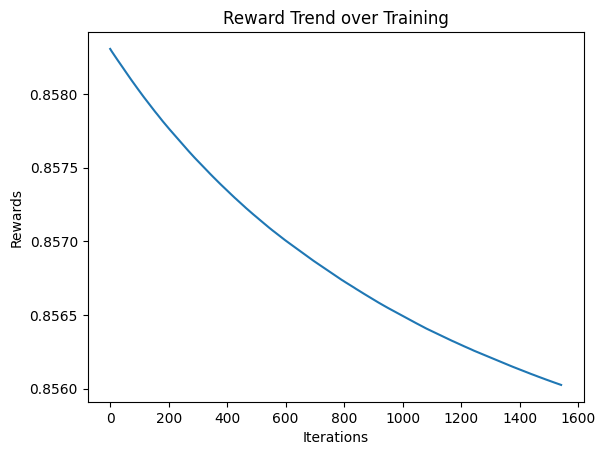

In [25]:
# Initialize lists to store evaluation results
eval = []
eval2 = []

# Concatenate the two DataFrames along axis 1 (columns)


# Optional: Reset the index of the concatenated DataFrame
df.reset_index(drop=True, inplace=True)

state_dim = df.shape[1]
action_dim = RewardVector.shape[1]
agent = ContextualBandit(state_dim, action_dim, alpha=0.00000001, steps=100, decay=0.999, batch_size=5000, eta=0.01)
globalaction = find_most_similar_action(result['weights'], np.array(agent.actions))  # example global action

model_path = "realfinaltest1.pkl"
save_interval = 500  # Save the model every 500 iterations

for j in range(150):
    a = np.random.randint(110, len(df) - 2000)
    
    agent.reset()
    for i in range(100):
        action = globalaction
        agent.GetReward(action, RewardVector.iloc[i + a])
    
    for i in range(500):
        state = df.iloc[i + a] * 100
        state_array = state.values.reshape(1, -1)
        result = state_array.reshape(1, 1, df.shape[1])
        
        action = agent.select_action(result, bool=True)
        reward = agent.GetReward(action, RewardVector.iloc[i + a])
        
        next_state = df.iloc[i + a + 1] * 100
        next_state_array = next_state.values.reshape(1, -1)
        result2 = next_state_array.reshape(1, 1, df.shape[1])
        done = False

        if i % 50 == 0 or agent.count == 500:
            agent.Remember(result, action, reward, result2, done)
            e1, e2, td = agent.learn()

            if isinstance(e1, np.ndarray) and isinstance(e2, np.ndarray):
                eval.append(np.mean(abs(td)))
                eval2.append(np.mean(e2))
        
        agent.Remember(result, action, reward, result2, done)

        if i % save_interval == 0:
            # Save the model periodically
            with open(model_path, 'wb') as f:
                pickle.dump(agent, f)
            print(f"Model saved at iteration {i} as {model_path}")

plt.plot(eval)
plt.xlabel('Iterations')
plt.ylabel('Rewards')
plt.title('Reward Trend over Training')
plt.show()

1/1 [==============================] - 0s 22ms/step
Actions taken during testing: [70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 7

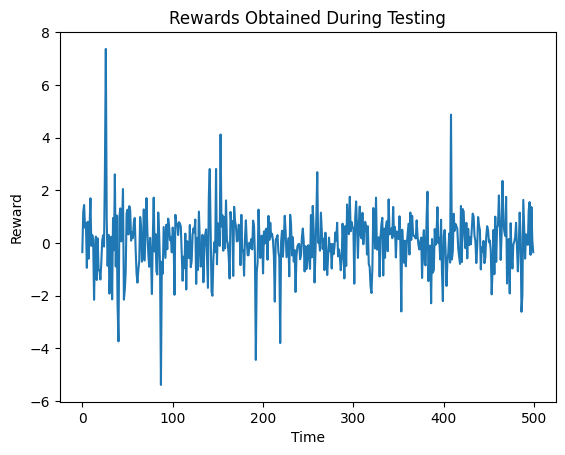

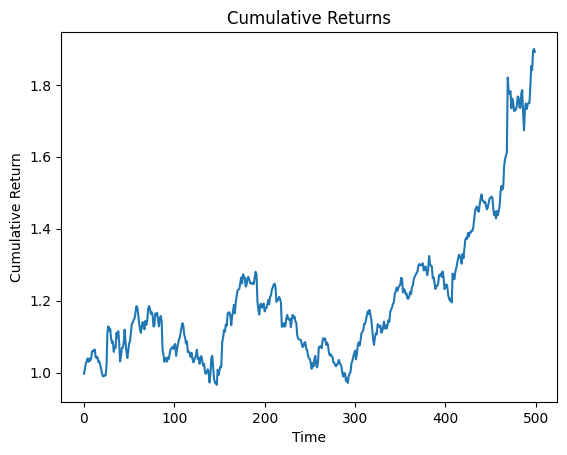

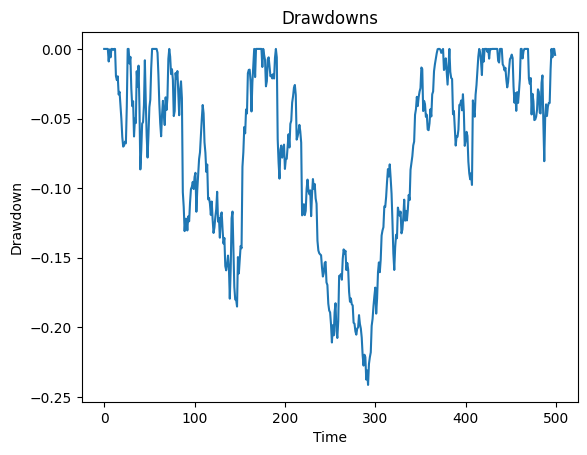

[(70, 500, 100.0)]


In [26]:
test_actions = []
test_rewards = []
rew = []

# Testing loop
agent.reset()
a = 0
for i in range(len(df) - 600, len(df)-500):
    action = globalaction
    agent.GetReward(action, RewardVector.iloc[i + a])

for i in range(len(df) - 500, len(df)):
    state = df.iloc[i + a] * 100
    state_array = state.values.reshape(1, -1)
    result = state_array.reshape(1, 1, df.shape[1])
    action = agent.select_action(result, bool=False)
    test_actions.append(action)
    reward = agent.GetReward(action, RewardVector.iloc[i + a])
    test_rewards.append(reward)
    actie = agent.actions[action%len(agent.actions)]
        
    Rt = np.dot(np.array(RewardVector.iloc[i + a]),np.array(actie))
    #print(np.array(RewardVector.iloc[i + a]),np.array(acti))
    rew.append(Rt)
        

# Convert test_rewards to a numpy array for calculations
rew = np.array(rew)

# Calculate Sharpe Ratio
# Calculate average return
average_return = np.mean(rew)

risk_free_rate = 0

# Calculate standard deviation of returns
std_dev_returns = np.std(rew)

# Compute the Sharpe Ratio
sharpe_ratio = (average_return - risk_free_rate) / std_dev_returns

# Convert log-normal returns to simple returns for cumulative calculations
simple_returns = np.exp(rew) - 1

# Compute cumulative returns
cumulative_returns = np.cumprod(1 + simple_returns)

# Calculate drawdowns
peak = np.maximum.accumulate(cumulative_returns)
drawdowns = (( cumulative_returns- peak) / peak)

# Find the maximum drawdown
max_drawdown = np.min(drawdowns)

# Print results
print("Actions taken during testing:", test_actions)
print("Rewards obtained during testing:", test_rewards)
print(f"Sharpe Ratio: {sharpe_ratio:.4f}")
print(f"Maximum Drawdown: {max_drawdown:.4f}")

# Plot rewards
plt.plot(test_rewards)
plt.title("Rewards Obtained During Testing")
plt.xlabel("Time")
plt.ylabel("Reward")
plt.show()

# Plot cumulative returns
plt.plot(cumulative_returns)
plt.title("Cumulative Returns")
plt.xlabel("Time")
plt.ylabel("Cumulative Return")
plt.show()

# Plot drawdowns
plt.plot(drawdowns)
plt.title("Drawdowns")
plt.xlabel("Time")
plt.ylabel("Drawdown")
plt.show()

from collections import Counter
action_counts = Counter(test_actions)


# Determine the five most common actions
most_common_actions = action_counts.most_common(5)

# Calculate the percentage of time each of these actions appears
total_actions = len(test_actions)
most_common_actions_percentages = [(action, count, (count / total_actions) * 100) for action, count in most_common_actions]

print(most_common_actions_percentages)

a1 =cumulative_returns
a1draw = drawdowns

Compute Tangency Portfolio

In [36]:
wi = tangency_weights(RewardVector.iloc[:-500].cov(), RewardVector.iloc[:-500].mean())

In [37]:
wi['weights']

array([0.93383887, 0.06616113])

In [24]:
veri = RewardVector.iloc[-500:]+1
veri.reset_index(drop= True, inplace = True)
veri

Stock_1_Close  Stock_2_Close
0         1.010704       0.999839
1         1.018449       1.013716
2         0.997316       1.011143
3         1.010595       1.007242
4         1.000166       1.006252
..             ...            ...
495       1.004704       1.025824
496       0.995151       0.994250
497       1.000504       1.021933
498       0.998153       1.001937
499       1.001346       0.996998

[500 rows x 2 columns]

In [25]:
veri = veri.cumprod()
veri

Stock_1_Close  Stock_2_Close
0         1.010704       0.999839
1         1.029351       1.013553
2         1.026588       1.024847
3         1.037466       1.032268
4         1.037638       1.038722
..             ...            ...
495       1.032631       1.557438
496       1.027624       1.548483
497       1.028142       1.582446
498       1.026243       1.585511
499       1.027624       1.580752

[500 rows x 2 columns]

<Figure size 1000x600 with 0 Axes>

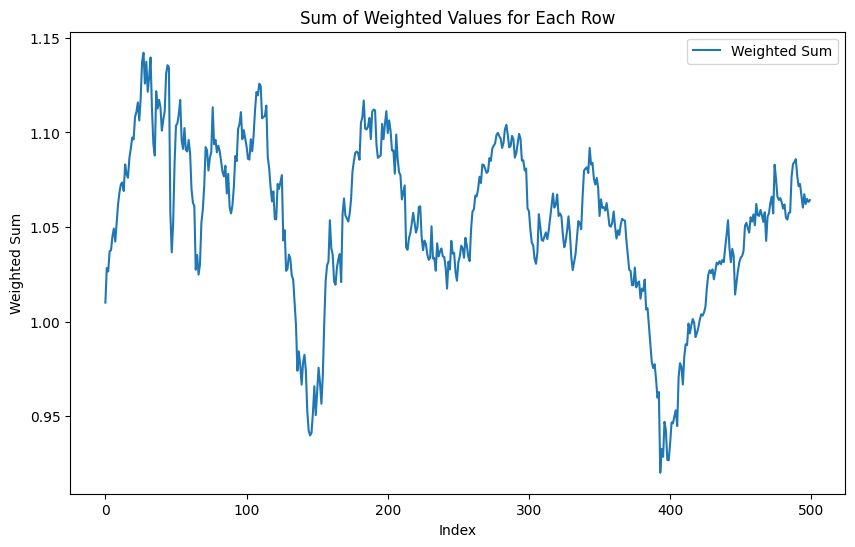

In [26]:
weighted_veri = veri * wi['weights']
weighted_sum = weighted_veri.sum(axis=1)

# Plot the result
plt.figure(figsize=(10, 6))

# Plot the result
plt.figure(figsize=(10, 6))
plt.plot(weighted_sum.index, weighted_sum, label='Weighted Sum')

# Adding labels and title
plt.xlabel('Index')
plt.ylabel('Weighted Sum')
plt.title('Sum of Weighted Values for Each Row')
plt.legend()

# Show the plot
plt.show()

Create Figures for Comparison

In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
from collections import Counter

# Load agents
with open('realfinaltest1.pkl', 'rb') as file:
    agent1 = pickle.load(file)
with open('realfinaltest2.pkl', 'rb') as file:
    agent2 = pickle.load(file)
with open('realfinaltest3.pkl', 'rb') as file:
    agent3 = pickle.load(file)

agents = [agent1, agent2, agent3]
agent_names = ["Agent 1", "Agent 2", "Agent 3"]
results = []

# Function to test an agent and calculate metrics
def test_agent(agent, df, RewardVector):
    test_actions = []
    test_rewards = []
    rew = []

    # Testing loop
    agent.reset()
    a = 0
    for i in range(len(df) - 600, len(df) - 500):
        action = globalaction
        agent.GetReward(action, RewardVector.iloc[i + a])

    for i in range(len(df) - 500, len(df)):
        state = df.iloc[i + a] * 100
        state_array = state.values.reshape(1, -1)
        result = state_array.reshape(1, 1, df.shape[1])
        action = agent.select_action(result, bool=False)
        test_actions.append(action)
        reward = agent.GetReward(action, RewardVector.iloc[i + a])
        test_rewards.append(reward)
        actie = agent.actions[action % len(agent.actions)]

        Rt = np.dot(np.array(RewardVector.iloc[i + a]), np.array(actie))
        rew.append(Rt)

    # Convert test_rewards to a numpy array for calculations
    rew = np.array(rew)

    # Calculate Sharpe Ratio
    average_return = np.mean(rew)
    risk_free_rate = 0
    std_dev_returns = np.std(rew)
    sharpe_ratio = (average_return - risk_free_rate) / std_dev_returns

    # Convert log-normal returns to simple returns for cumulative calculations
    simple_returns = rew

    # Compute cumulative returns
    cumulative_returns = np.cumprod(1 + simple_returns)

    # Calculate drawdowns
    peak = np.maximum.accumulate(cumulative_returns)
    drawdowns = ((cumulative_returns - peak) / peak)
    max_drawdown = np.min(drawdowns)

    # Action frequency
    action_counts = Counter(test_actions)
    most_common_actions = action_counts.most_common(5)
    total_actions = len(test_actions)
    most_common_actions_percentages = [(action, count, (count / total_actions) * 100) for action, count in most_common_actions]

    return {
        "sharpe_ratio": sharpe_ratio,
        "max_drawdown": max_drawdown,
        "cumulative_returns": cumulative_returns,
        "drawdowns": drawdowns,
        "action_frequencies": most_common_actions_percentages
    }

# Test each agent and collect results
for agent in agents:
    result = test_agent(agent, df, RewardVector)
    results.append(result)




1/1 [==============================] - 0s 17ms/step


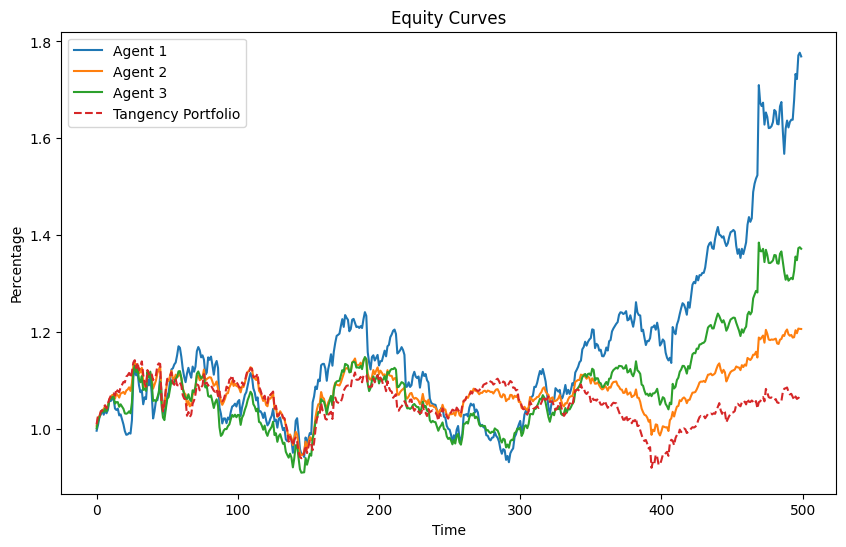

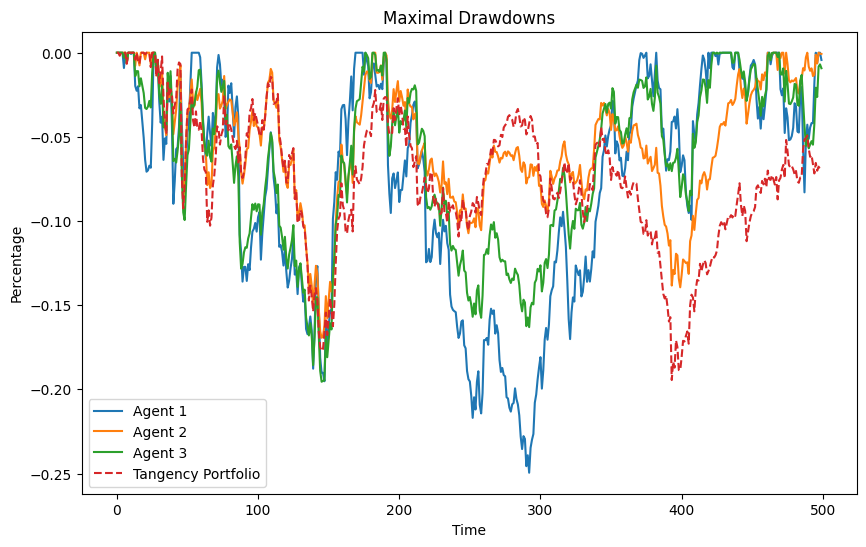

Agent 1:
Sharpe Ratio: 0.0777
Maximum Drawdown: -0.2495
[-0.29999999999999993, 1.2999999999999998]
Most Common Actions (action, count, percentage): [(70, 500, 100.0)]


Agent 2:
Sharpe Ratio: 0.0443
Maximum Drawdown: -0.1693
[0.6500000000000001, 0.34999999999999987]
Most Common Actions (action, count, percentage): [(165, 500, 100.0)]


Agent 3:
Sharpe Ratio: 0.0589
Maximum Drawdown: -0.1955
[0.15999999999999992, 0.8400000000000001]
[1.4100000000000001, -0.41000000000000014]
Most Common Actions (action, count, percentage): [(116, 486, 97.2), (241, 14, 2.8000000000000003)]


Veri Maximum Drawdown: -0.1944


In [31]:
# Calculate cumulative return and drawdown for veri

weighted_veri = veri * wi['weights']
weighted_sum = weighted_veri.sum(axis=1)

simple_returns_veri = weighted_sum
cumulative_returns_veri = weighted_sum
peak_veri = np.maximum.accumulate(cumulative_returns_veri)
drawdowns_veri = ((cumulative_returns_veri - peak_veri) / peak_veri)
max_drawdown_veri = np.min(drawdowns_veri)

# Plot cumulative returns
plt.figure(figsize=(10, 6))
for idx, result in enumerate(results):
    plt.plot(result["cumulative_returns"], label=f'{agent_names[idx]}')
plt.plot(cumulative_returns_veri, label='Tangency Portfolio', linestyle='--')
plt.xlabel('Time')
plt.ylabel('Percentage')
plt.title('Equity Curves')
plt.legend()
plt.savefig('cumreturnverification2.png')
plt.show()

# Plot drawdowns
plt.figure(figsize=(10, 6))
for idx, result in enumerate(results):
    plt.plot(result["drawdowns"], label=f'{agent_names[idx]}')
plt.plot(drawdowns_veri, label='Tangency Portfolio', linestyle='--')
plt.xlabel('Time')
plt.ylabel('Percentage')
plt.title('Maximal Drawdowns')
plt.legend()
plt.savefig('drawdownverification2.png')
plt.show()

# Print results
for idx, result in enumerate(results):
    print(f"{agent_names[idx]}:")
    print(f"Sharpe Ratio: {result['sharpe_ratio']:.4f}")
    print(f"Maximum Drawdown: {result['max_drawdown']:.4f}")
    for i in range(len(result['action_frequencies'])):
        print(agent.actions[result['action_frequencies'][i][0]])
    print(f"Most Common Actions (action, count, percentage): {result['action_frequencies']}")
    print("\n")

# Print veri's max drawdown
print(f"Veri Maximum Drawdown: {max_drawdown_veri:.4f}")